# Visualization of data

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

In [2]:
path_data = Path("data")
path_img = Path("img")
path_autoenc = Path("out_autoenc")
path_mlp = Path("out_mlp")

In [48]:
palette = {0: "green", 1:"red", 2: "yellow"}

In [186]:
def plot_confusion(conf_mtx, labels=[0, 1, 2], palette=palette, title="Confusion Matrix"):
    n = len(labels)
    fig, axs = plt.subplots(1, n, figsize=(4*n, 4), sharey=True)
    fig.suptitle(title)
    for i, ax in enumerate(axs):
        sns.barplot(x=list(range(n)), y=conf_mtx[i], ax=ax, hue=list(range(n)), palette=palette)
        for j in range(n):
            ax.bar_label(ax.containers[j])
        ax.set_xlabel(f"Actual = {i}")
    return fig, axs

## Load Data

In [12]:
y_true = pd.read_csv(path_data / "y_clf.csv").squeeze()
y_true.head()

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int64

<Axes: xlabel='Label'>

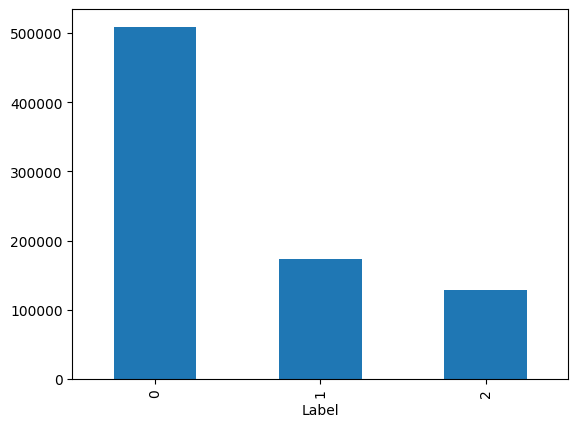

In [8]:
y_true.groupby(y_true).count().plot.bar()

## Autoencoder

In [18]:
rec_err = pd.read_csv(path_autoenc / "rec_err.csv")["reconstruction_error"]
rec_err.head()

0    0.000663
1    0.000100
2    0.000097
3    0.000096
4    0.000663
Name: reconstruction_error, dtype: float64

### Check Reconstruction Error & the Default Threshold

In [26]:
default_pct = 90

default_threshold_val = np.percentile(rec_err.values, default_pct)
print(default_threshold_val)

0.012836991141085781


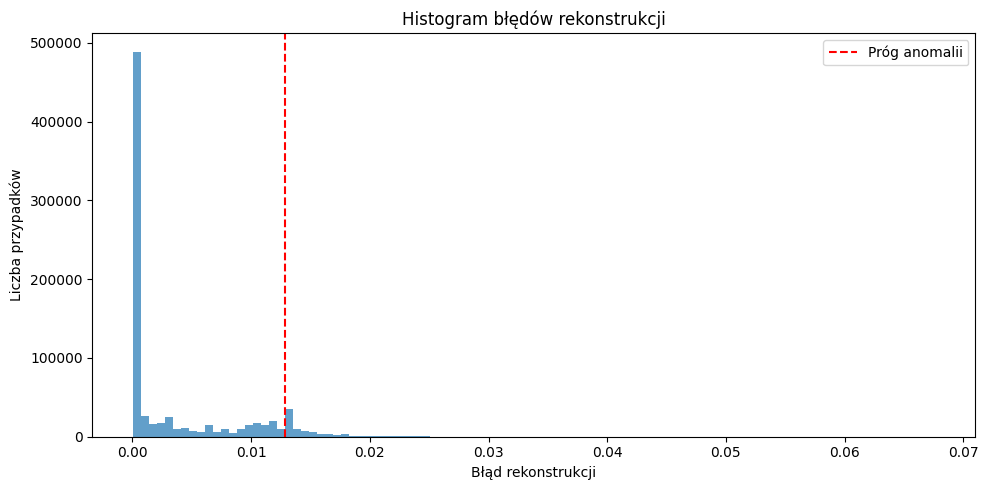

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(rec_err, bins=100, alpha=0.7)
plt.axvline(default_threshold_val, color='red', linestyle='--', label='Próg anomalii')
plt.title("Histogram błędów rekonstrukcji")
plt.xlabel("Błąd rekonstrukcji")
plt.ylabel("Liczba przypadków")
plt.legend()
plt.tight_layout()

Nicer plots

In [29]:
df1 = pd.DataFrame({"rec_err": rec_err, "y_true": y_true})

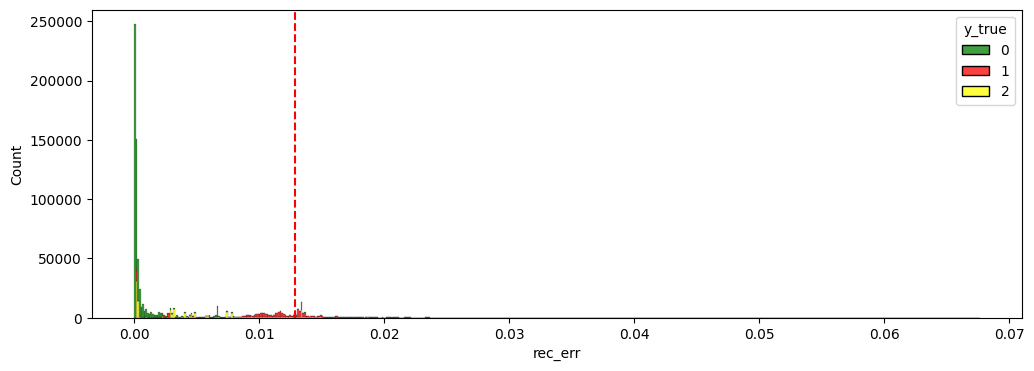

In [49]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(df1, x="rec_err", hue="y_true", palette=palette,multiple="stack", ax=ax)
ax.axvline(default_threshold_val, color='red', linestyle='--', label='Próg anomalii')

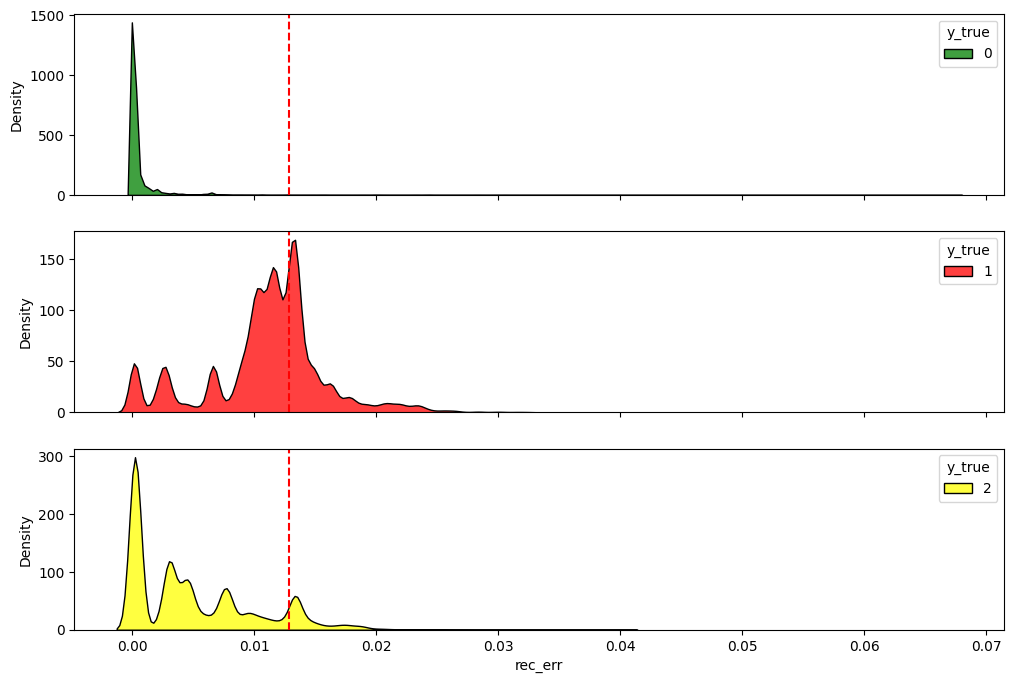

In [50]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for i, ax in enumerate(axs):
    # sns.histplot(df1[df1["y_true"] == i], x="rec_err", hue="y_true", palette=palette,multiple="stack", ax=ax)
    sns.kdeplot(df1[df1["y_true"] == i], x="rec_err", hue="y_true", palette=palette,multiple="stack", ax=ax)
    ax.axvline(default_threshold_val, color='red', linestyle='--', label='Próg anomalii')


### Sweep through thresholds

In [129]:
pcts = np.arange(50, 100, step=1)
thresholds = np.percentile(rec_err.values, pcts)

In [132]:
y_isbad = (y_true != 0)
df_per_threshold = pd.DataFrame(np.astype(rec_err.values[:, np.newaxis] > thresholds[np.newaxis, :], int), columns=pcts)
eq_per_threshold = df_per_threshold.apply(lambda col: (col==y_isbad).astype(int), axis="rows")
df_res = pd.DataFrame(
    {
        "pct": pcts,
        "threshold": thresholds,
        "accuracy": eq_per_threshold.mean(axis="rows"),
        "recall": df_per_threshold.apply(lambda col: recall_score(y_isbad, col), axis="rows"),
        "precision": df_per_threshold.apply(lambda col: precision_score(y_isbad, col), axis="rows"),
        "f1": df_per_threshold.apply(lambda col: f1_score(y_isbad, col), axis="rows"),
    }
).set_index("pct")
df_res.head()

,threshold,accuracy,recall,precision,f1
pct,,,,,
50,0.000273,0.768434,0.861314,0.639901,0.734280
51,0.000286,0.773161,0.854218,0.647580,0.736683
52,0.000307,0.776597,0.845383,0.654234,0.737626
53,0.000328,0.779910,0.836382,0.661040,0.738445
54,0.000351,0.783724,0.828056,0.668686,0.739886


In [ ]:
metrics = ["accuracy", "recall", "precision", "f1"]
optimal_vals = {}
for metric in metrics:
    optimal_pct_i = df_res[metric].idxmax()
    optimal_thresh_i = df_res.loc[optimal_pct_i, "threshold"]
    optimal_vals[metric] = (optimal_pct_i, optimal_thresh_i)

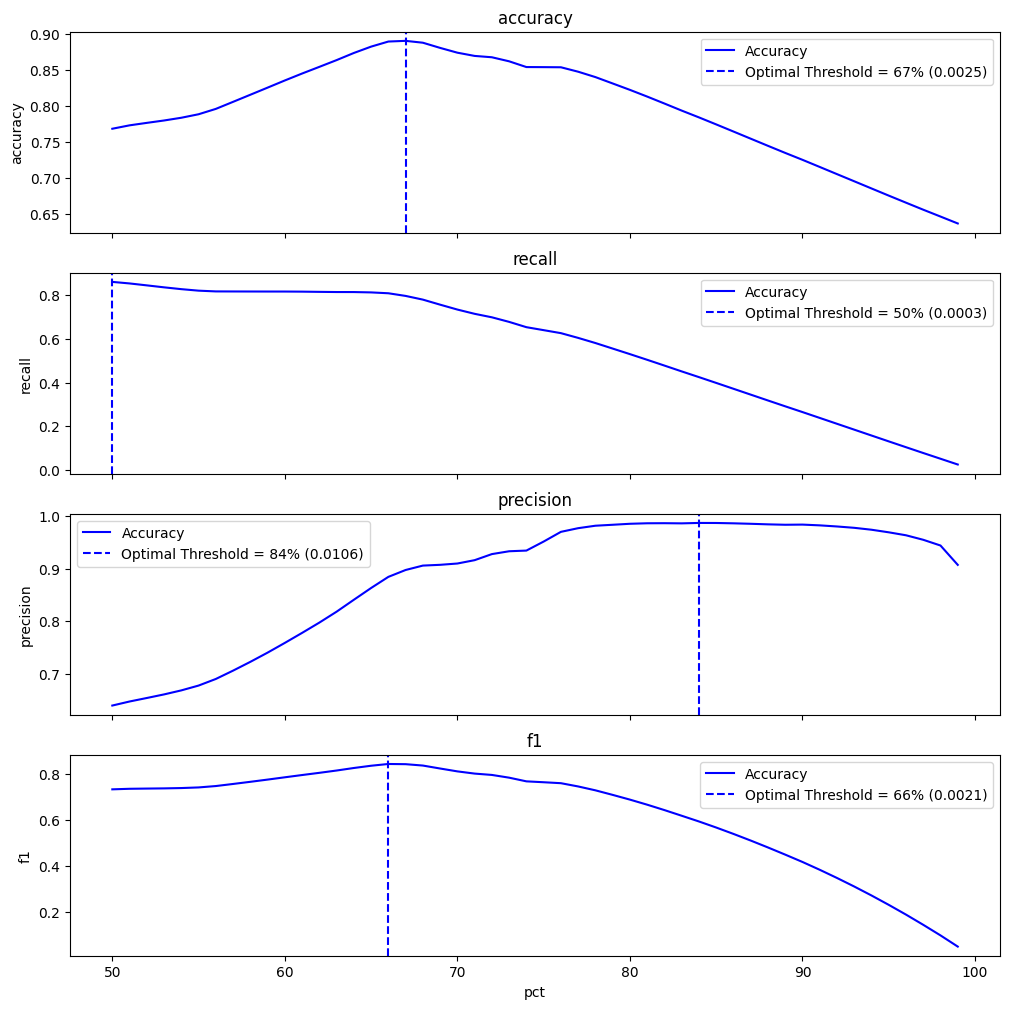

In [ ]:
fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 3 * len(metrics)), sharex=True)

# Accuracy
for i, metric in enumerate(metrics):
    ax = axs[i]
    ax.set_title(f"{metric}")
    sns.lineplot(df_res, x=df_res.index, y=metric, color="blue", label="Accuracy", ax=ax)
    pct, thresh = optimal_vals[metric]
    ax.axvline(pct, linestyle="--", color="blue", label=f"Optimal Threshold = {pct}% ({thresh:.4f})")
    ax.legend()

### Best Threshold

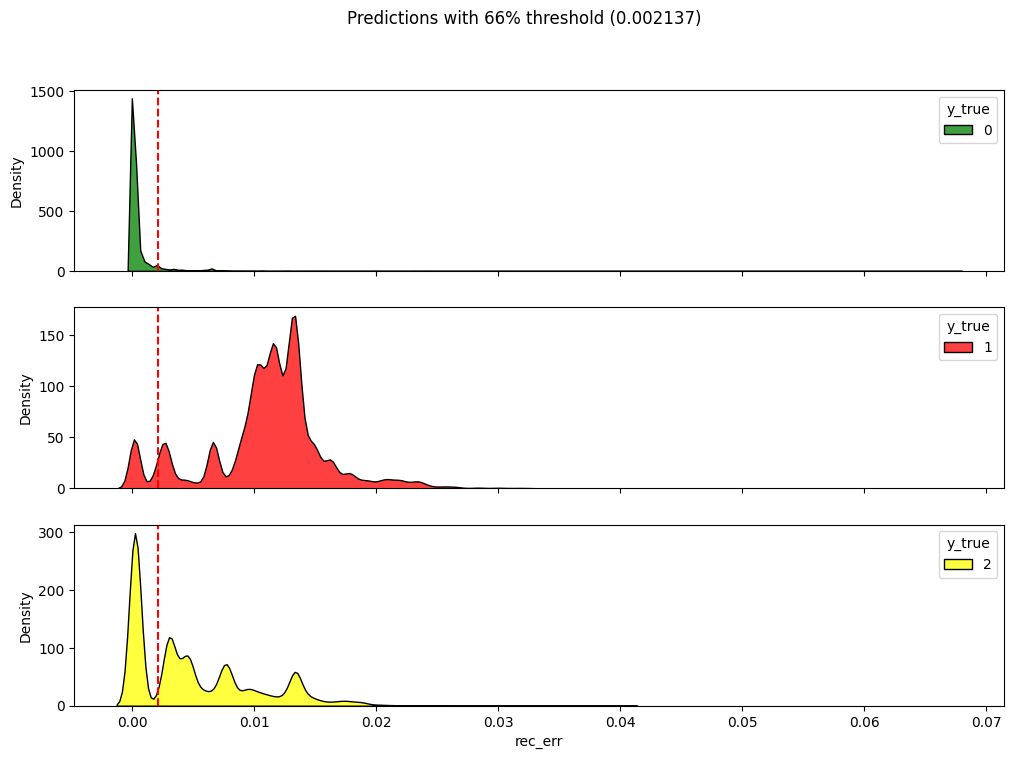

In [ ]:
best_pct = 66
best_thresh = np.percentile(rec_err.values, best_pct)
df2 = pd.DataFrame({"y_true": y_true, "y_isbad": y_isbad, "rec_err": rec_err, "best_pred": df_per_threshold[best_pct]})

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle(f"Predictions with {best_pct}% threshold ({best_thresh:.04})")
for i, ax in enumerate(axs):
    sns.kdeplot(df2[df2["y_true"] == i], x="rec_err", hue="y_true", palette=palette, multiple="stack", ax=ax)
    ax.axvline(best_thresh, color='red', linestyle='--', label='Próg anomalii')


### Main Metrics

In [149]:
print(classification_report(df2["y_isbad"], df2["best_pred"], digits=4))

              precision    recall  f1-score   support

       False     0.8926    0.9373    0.9144    509063
        True     0.8841    0.8092    0.8450    300860

    accuracy                         0.8897    809923
   macro avg     0.8884    0.8733    0.8797    809923
weighted avg     0.8895    0.8897    0.8886    809923



In [178]:
conf_aenc = confusion_matrix(df2["y_isbad"], df2["best_pred"])
conf_aenc

array([[477159,  31904],
       [ 57405, 243455]])

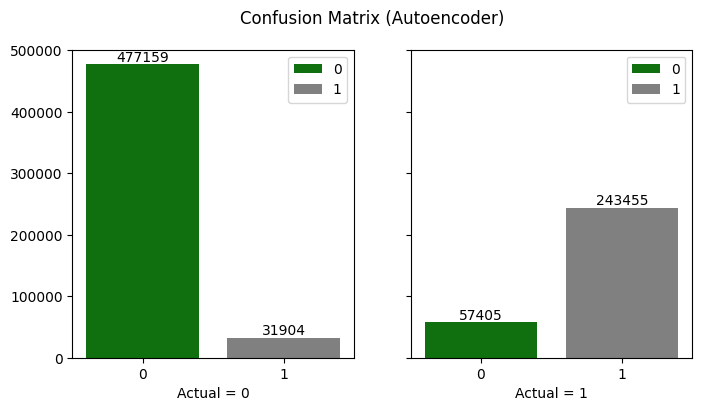

In [187]:
plot_confusion(conf_aenc, labels=[0, 1], palette={0: palette[0], 1: "grey"}, title="Confusion Matrix (Autoencoder)");

## MLP

In [143]:
df_mlp = pd.read_csv(path_mlp / "predictions.csv")
df_mlp["prob_bad"] = df_mlp["prob_1"] + df_mlp["prob_2"]
df_mlp

,prob_0,prob_1,prob_2,pred,y_true,prob_bad
0,9.999860e-01,2.271973e-07,1.370703e-05,0,0,1.393422e-05
1,8.847034e-06,1.388867e-06,9.999898e-01,2,2,9.999911e-01
2,9.999450e-01,5.153344e-06,4.980439e-05,0,0,5.495774e-05
3,7.089734e-08,9.999994e-01,4.976916e-07,1,1,9.999999e-01
4,9.999737e-01,1.784398e-05,8.438600e-06,0,0,2.628258e-05
...,...,...,...,...,...,...
161980,2.325664e-07,2.698691e-06,9.999970e-01,2,2,9.999997e-01
161981,1.012850e-06,9.999958e-01,3.211665e-06,1,1,9.999990e-01
161982,9.999802e-01,9.960374e-06,9.766345e-06,0,0,1.972672e-05
161983,9.999428e-01,2.882888e-05,2.833809e-05,0,0,5.716696e-05


### Main Metrics

In [145]:
print(classification_report(df_mlp["y_true"], df_mlp["pred"], digits=4))

              precision    recall  f1-score   support

           0     0.9988    0.9681    0.9832    101813
           1     0.9548    0.9969    0.9754     34569
           2     0.9405    0.9994    0.9691     25603

    accuracy                         0.9792    161985
   macro avg     0.9647    0.9881    0.9759    161985
weighted avg     0.9802    0.9792    0.9793    161985



In [156]:
conf_mlp = confusion_matrix(df_mlp["y_true"], df_mlp["pred"])
conf_mlp

array([[98567,  1632,  1614],
       [  103, 34461,     5],
       [   15,     0, 25588]])

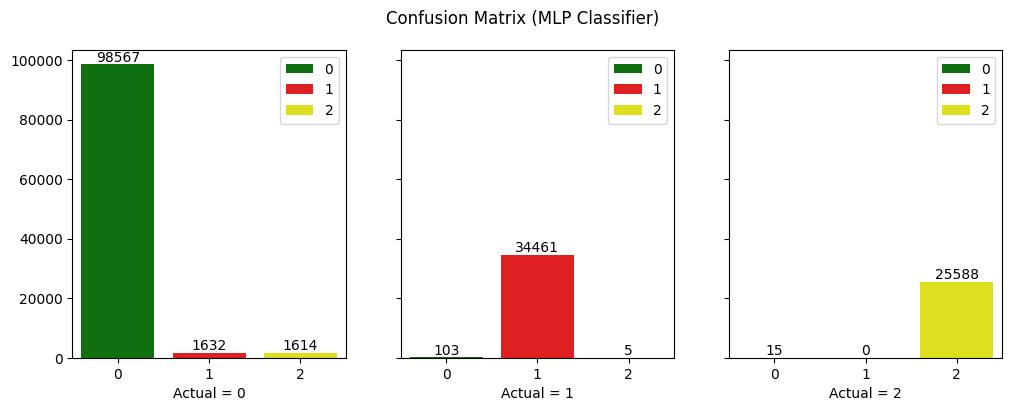

In [188]:
plot_confusion(conf_mlp, title="Confusion Matrix (MLP Classifier)");

### Plot

In [150]:
df_mlp.head()

,prob_0,prob_1,prob_2,pred,y_true,prob_bad
0,9.999860e-01,2.271973e-07,1.370703e-05,0,0,0.000014
1,8.847034e-06,1.388867e-06,9.999898e-01,2,2,0.999991
2,9.999450e-01,5.153344e-06,4.980439e-05,0,0,0.000055
3,7.089734e-08,9.999994e-01,4.976916e-07,1,1,1.000000
4,9.999737e-01,1.784398e-05,8.438600e-06,0,0,0.000026


ROC and PR (binary case)

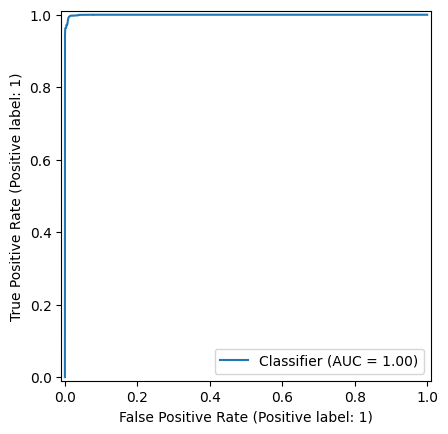

In [ ]:
RocCurveDisplay.from_predictions((df_mlp["y_true"]!=0).astype(int), df_mlp["prob_bad"])

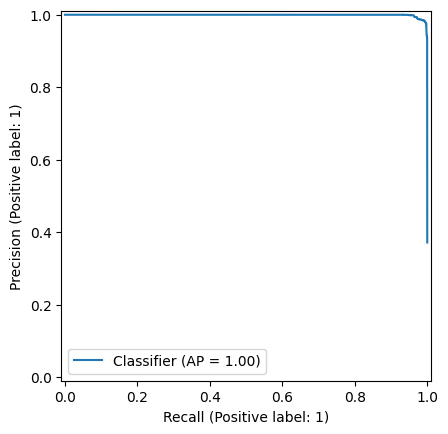

In [193]:
PrecisionRecallDisplay.from_predictions((df_mlp["y_true"]!=0).astype(int), df_mlp["prob_bad"])

Misclassified Points

<Axes: xlabel='prob_1', ylabel='prob_2'>

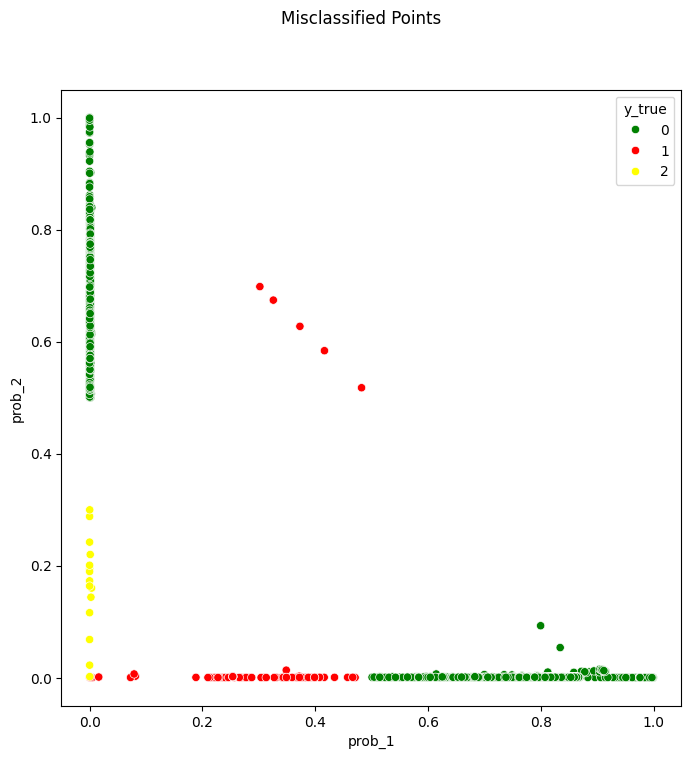

In [ ]:
df_mlp_fail = df_mlp[df_mlp["pred"] != df_mlp["y_true"]]

fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle("Misclassified Points")
sns.scatterplot(df_mlp_fail, x="prob_1", y="prob_2", hue="y_true", ax=ax, palette=palette)